# Automated Derivation of Text Structure as Circuits

QPL 2023

In [1]:
# import this before starting
from discocirc.pipeline.text_to_circuit import text_to_circuit

c:\Users\New User\PY-VENVS\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\New User\PY-VENVS\venv\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
c:\Users\New User\PY-VENVS\venv\lib\site-packages\discopy\messages.py:95: UserWarning: Since discopy v0.4.3 the behaviour of permutation has changed. Pass inverse=False to get the default behaviour.
  warnings.warn(message)


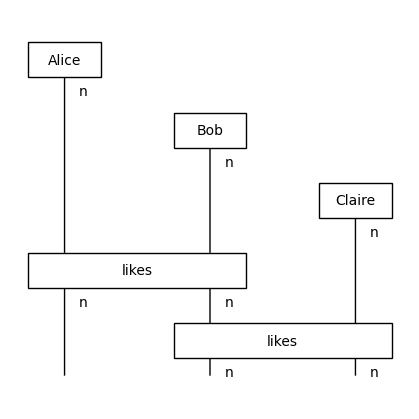

In [3]:
text_to_circuit("Alice likes Bob. Bob likes Claire.").draw(figsize=(4,4))

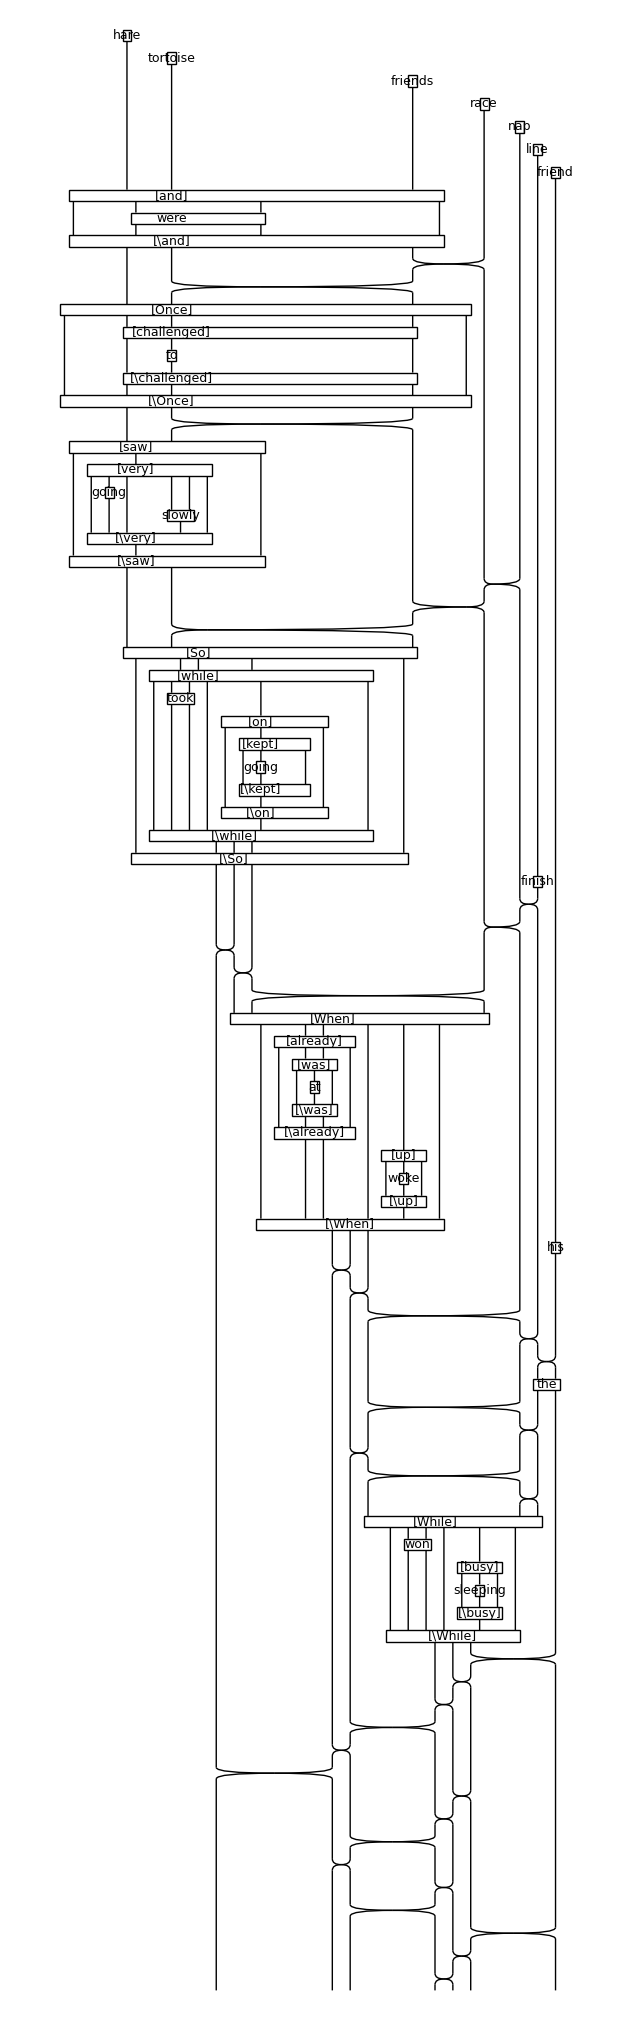

In [4]:
text = "A hare and a tortoise were friends. Once the hare challenged the tortoise to a race. \
The hare saw that the tortoise was going very slowly. So the hare took a nap while the tortoise kept on going. \
When the hare woke up, the tortoise was already at the finish line. \
While the hare was busy sleeping, his friend the tortoise won the race."

fig_config = {"figsize": (6,20), "fontsize": 9, "draw_type_labels": False, "margins": (0.1, 0.01)}

text_to_circuit(text).draw(**fig_config)

# Example: Alice loves Bob

### Parse the sentence, generate a lambda expression

In [5]:
from lambeq import BobcatParser
parser = BobcatParser()

In [6]:
ccg_tree = parser.sentence2tree("Alice loves Bob")
from discocirc.expr.ccg_to_expr import ccg_to_expr
expr1 = ccg_to_expr(ccg_tree)
expr1

    loves      Bob       
═════════════  ═══       
(n → (n → s))   n   Alice
──────────────────  ═════
     (n → s)          n  
─────────────────────────
            s            

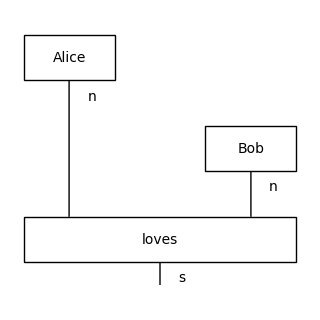

In [7]:
from discocirc.expr.expr_to_diag import draw_expr
draw_expr(expr1, figsize=(3,3))

### S-type expansion

In [8]:
from discocirc.expr.s_type_expand import s_type_expand
expr2 = s_type_expand(expr1)
expr2

      loves        Bob       
═════════════════  ═══       
(n → (n → n @ n))   n   Alice
──────────────────────  ═════
     (n → n @ n)          n  
─────────────────────────────
            n @ n            

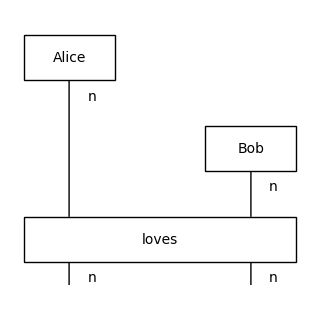

In [9]:
draw_expr(expr2, figsize=(3,3))

# Example: Alice quickly ran
### frames AKA higher-order boxes

In [10]:
ccg_tree = parser.sentence2tree("Alice quickly ran")
expr1 = ccg_to_expr(ccg_tree)
expr1

      quickly          ran         
═══════════════════  ═══════       
((n → s) → (n → s))  (n → s)  Alice
────────────────────────────  ═════
          (n → s)               n  
───────────────────────────────────
                 s                 

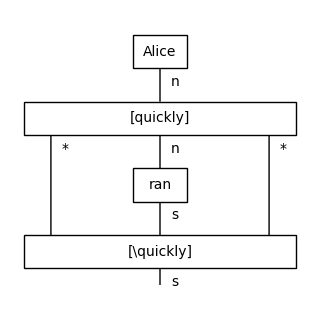

In [11]:
draw_expr(expr1, figsize=(3,3))

In [ ]:
expr2 = s_type_expand(expr1)
draw_expr(expr2, figsize=(3,3))

# Example: I really like Bob
### pulling out of frames

In [ ]:
ccg_tree = parser.sentence2tree("I really like Bob")
expr1 = ccg_to_expr(ccg_tree)
draw_expr(expr1, figsize=(3,3))

In [ ]:
expr1

The state "Bob" is trapped inside the frame. We need to 'pull it out' to the top, so that the "Bob" wire can compose at the top with other circuits

In [ ]:
from discocirc.expr.pull_out import pull_out
expr2 = pull_out(expr1)
draw_expr(expr2, figsize=(3,3))

In [ ]:
expr3 = s_type_expand(expr2)
draw_expr(expr3, figsize=(3,3))

# Example: Bob who loves Alice runs
### N-type expansion

In [ ]:
ccg_tree = parser.sentence2tree("Bob who loves Alice runs")
expr1 = ccg_to_expr(ccg_tree)
draw_expr(expr1, figsize=(3,3))

In [ ]:
expr2 = pull_out(expr1)
draw_expr(expr2, figsize=(3,3))

This is an interesting situation. "Bob who loves Alice" is treated as a single noun phrase which has the head "Bob". Diagrammatically, this corresponds to a single n-type wire.

Below, we show what happens if we just naively apply s-type expansion to the diagram.

In [ ]:
expr3 = s_type_expand(expr2)
draw_expr(expr3, figsize=(3,3))

This is no good. We have two nouns at the top but only one at the bottom (which can be interpreted as representing "Bob"). Ideally we would also like to be able to access "Alice" as an outgoing wire. So, we need to expand the n-type wire of "Bob who loves Alice" into two n-type wires -- one representing "Bob" and one representing "Alice". 

Note also that as per the sentence "Bob who loves Alice runs", only "Bob" is doing the running, not "Alice". So after we expand the n-type wire into two, we need to ensure only the one corresponding to head grammatical head "Bob" is fed into "runs".

In [ ]:
from discocirc.expr.n_type_expand import n_type_expand
expr4 = n_type_expand(expr2)
draw_expr(expr4, figsize=(3,3))

This is much better. After performing this n-type expansion, we can do the s-type expansion as usual

In [ ]:
expr5 = s_type_expand(expr4)
draw_expr(expr5, figsize=(3,3))

# Example: Alice and Bob quickly drink tea
### Coordination-of-nouns expansion

In [ ]:
ccg_tree = parser.sentence2tree("Alice and Bob quickly drink tea")
expr1 = ccg_to_expr(ccg_tree)
expr2 = pull_out(expr1)
draw_expr(expr2, figsize=(3,3))

In [ ]:
from discocirc.expr.coordination_expand import coordination_expand
expr3 = coordination_expand(expr2)
draw_expr(expr3, figsize=(3,3))

In [ ]:
expr4 = pull_out(expr3)
draw_expr(expr4, figsize=(3,3))

In [ ]:
expr5 = n_type_expand(expr4)
expr6 = s_type_expand(expr5)
draw_expr(expr6, figsize=(3,3))

# Example: Bob drinks his tea
### Possessive pronouns coreference

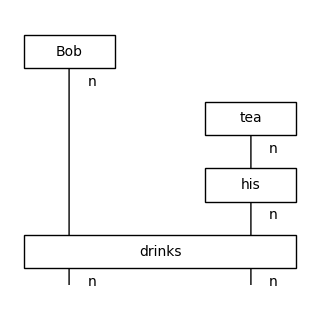

In [12]:
from discocirc.expr.pull_out import pull_out
from discocirc.expr.coordination_expand import coordination_expand
from discocirc.expr.n_type_expand import n_type_expand

sentence = "Bob drinks his tea"
ccg_tree = parser.sentence2tree(sentence)
expr1 = ccg_to_expr(ccg_tree)
expr2 = pull_out(expr1)
expr3 = coordination_expand(expr2)
expr4 = pull_out(expr3)
expr5 = n_type_expand(expr4)
expr6 = s_type_expand(expr5)
draw_expr(expr6, figsize=(3,3))

In [2]:
# load this beforehand
import spacy
spacy_model = spacy.load('en_core_web_trf')
spacy_model.add_pipe('coreferee')

In [13]:
spacy_sentence = spacy_model(sentence)
spacy_sentence._.coref_chains

[0: [0], [2]]

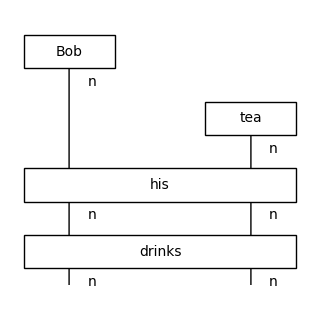

In [14]:
from discocirc.expr.expr_expand_pronouns import expand_coref
expr7 = expand_coref(expr6, spacy_sentence)
draw_expr(expr7, figsize=(3,3))

# Multiple sentences

In [ ]:
from discocirc.pipeline.text_to_circuit import sentence_list_to_circuit

In [ ]:
sentence_list_to_circuit(["Alice likes Bob", "Bob drinks tea"]).draw(figsize=(4,4))

# Converting to a quantum circuit

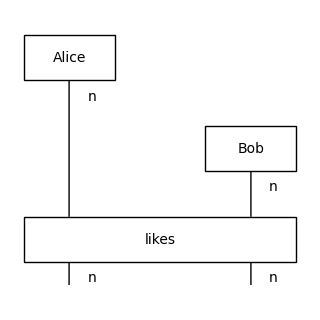

In [15]:
diag = text_to_circuit("Alice likes Bob")
diag.draw(figsize=(3,3))

In [16]:
from lambeq.ansatz.circuit import Sim14Ansatz
from discopy import monoidal

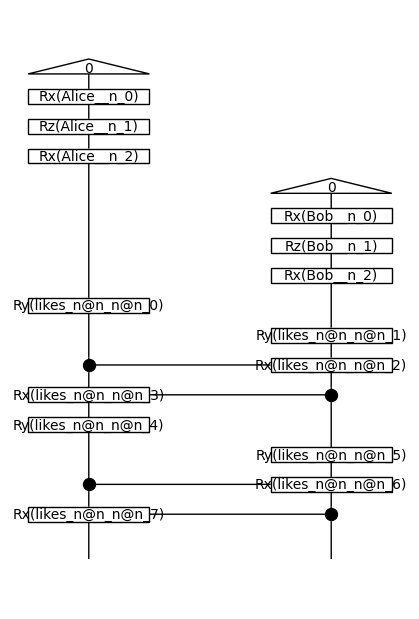

In [17]:
Sim14Ansatz({monoidal.Ty('n'): 1,}, n_layers=1)(diag).draw(figsize=(4, 6))

# Frames in quantum circuits

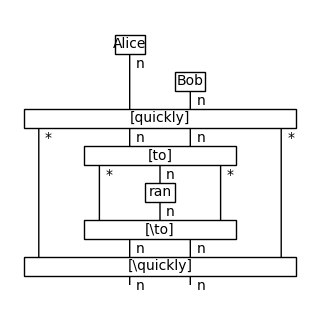

In [18]:
diag = text_to_circuit("Alice quickly ran to Bob")
diag.draw(figsize=(3,3))

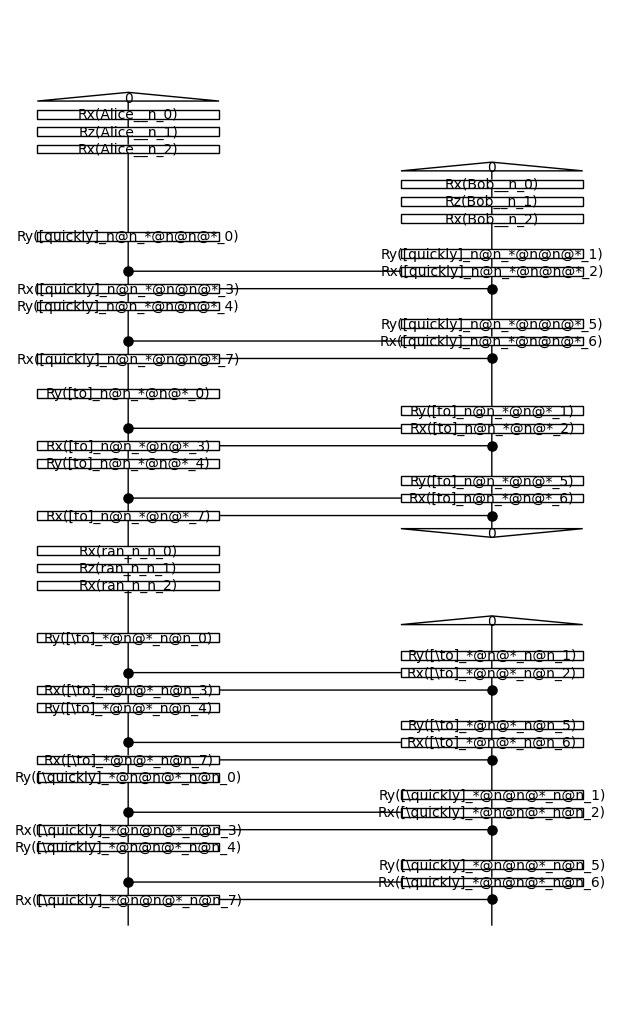

In [19]:
Sim14Ansatz({monoidal.Ty('n'): 1, monoidal.Ty('*'): 0}, n_layers=1)(diag).draw(figsize=(6,10))

Has postselection - maybe undesirable

An alternative way to deal with frames that avoids this:

In [20]:
from sandwich import to_qdiscocirc

In [21]:
diag = text_to_circuit("Alice quickly ran to Bob", frame_expansion=True)

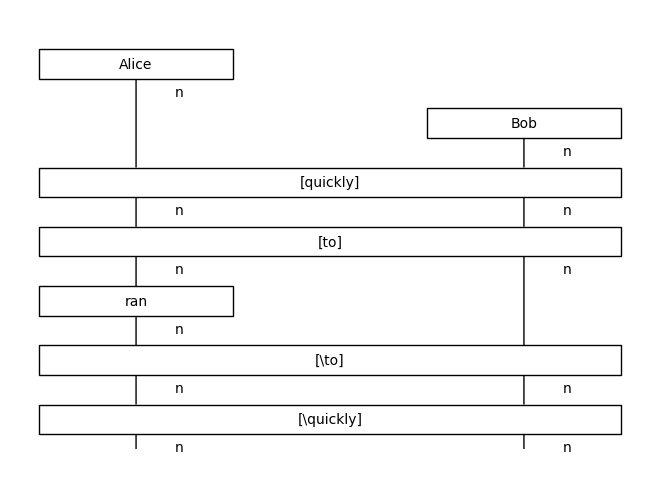

In [22]:
diag = to_qdiscocirc(diag)
diag.draw()

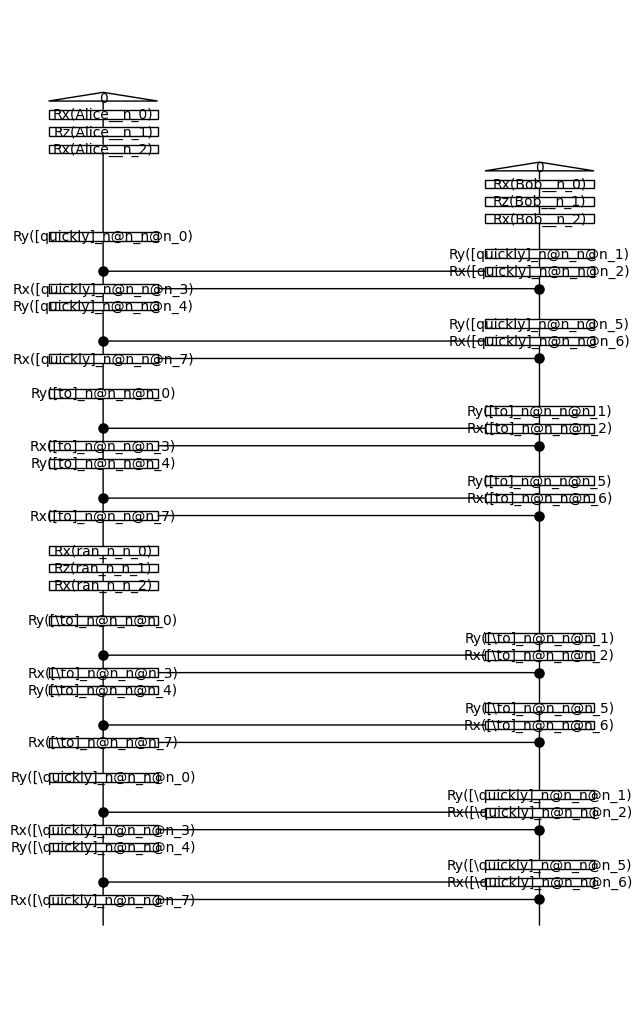

In [23]:
Sim14Ansatz({monoidal.Ty('n'): 1}, n_layers=1)(diag).draw(figsize=(6,10))